# **The Architecture**

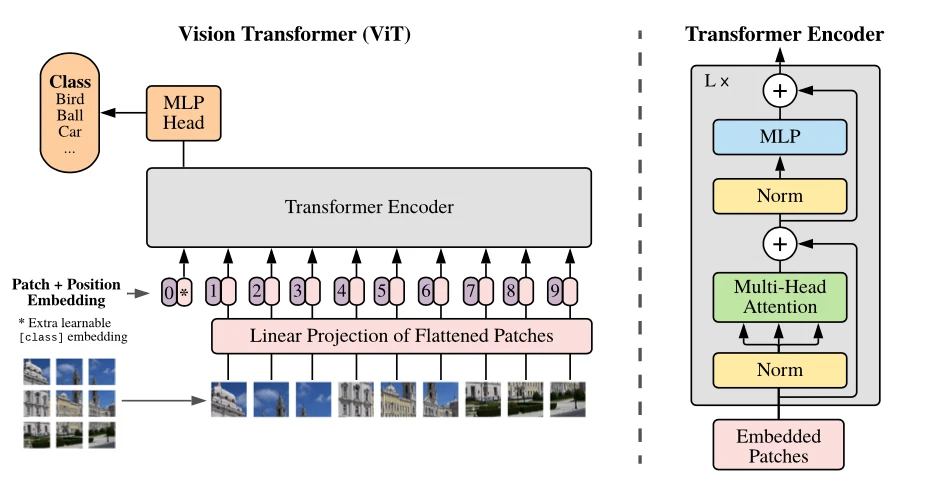

Vision transformer works on the basis on the following Steps : 

1. The input image is passed **Augmented** to make the **model robust** and also to **increase the size** of the **image dataset**. 

2. These Augmented images are then chopped into **Pathches/Chunks**. Each Patch is simply the sliced part of the Image.

 * Now these pathches can be created using **Conv Layers** with the right **Kernel Size and Strides**.

 * Other way is to simply **Chop the Image** without passing it through a network using **Tensorflow Image** module.

3. These **Pathches of Images** are then passed to a **Dense Layer** which learns the **Image Data** and also the **Positional Embedding** of each patch.

 * This **Positional Embedding** allow the network to understand the **Representation** of all the **Pathces as a Single Image**.

4. Then the **Ouput** is passed to a **Transformer Network** for **L time**. This transformer network consist of :

 * A normalization layer followed by a **Multi-Head Attention** layer, this **Multi-Head Attention** layer allow the model to undestand the **relatioship between these different Patches**.

 * The outputs are then added to the **Original Inputs** as a form of **Residual learning** so that the **Gradients** can flow easily during **BackPropogation**.

 * These **refined Outputs** are again passed through a **Normalization Layer** followed by a **MLP** which learns about the **Classes** and at **lower level** understand the **Attention Areas.** 

5. Finally, the outputs of the **Transformer Block(last)** is passed to a **MLP** which outputs the final **Class probabilities**.

---
$Note :$

This model only works when the dataset is **not just big it is Large**. The model was only able to **Outperform ResNet50** when the Number of Image in **Training Dataset** went above $300M$.

---

# **Imports**

In [20]:
# !pip install -U tensorflow_addons

In [21]:
# Common
import keras
import numpy as np
import tensorflow as tf
from tensorflow import image as tfi

# Data
from keras.datasets import cifar100

# Data Viz
import matplotlib.pyplot as plt

# Data Aug
from keras.layers import Normalization
from keras.layers import Resizing
from keras.layers import RandomFlip
from keras.layers import RandomRotation
from keras.layers import RandomZoom


# Model
from tensorflow.nn import gelu
from keras.models import Model
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
from keras.layers import Add
from keras.layers import Flatten

# Compiling
from keras.losses import SparseCategoricalCrossentropy as SCCe
from tensorflow_addons.optimizers import AdamW
from keras.metrics import SparseCategoricalAccuracy as Acc
from keras.metrics import SparseTopKCategoricalAccuracy as KAcc

# Callbacks 
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)])

# **Functions**

In [22]:
def show_image(image, title=None, cmap=None):
    plt.imshow(image, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# **Load Data**

$Remember :$ It is a small dataset so don't expect a Super Human Performance.

In [23]:
(X_train, y_train), (X_valid, y_valid) = cifar100.load_data()

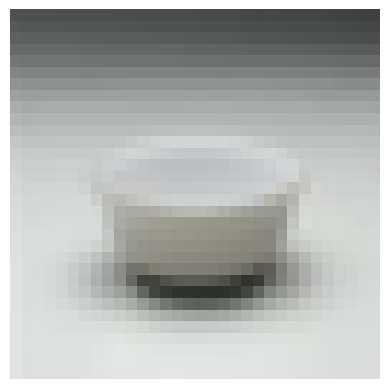

In [24]:
image = X_train[np.random.randint(len(X_train))]
show_image(image)
plt.show()

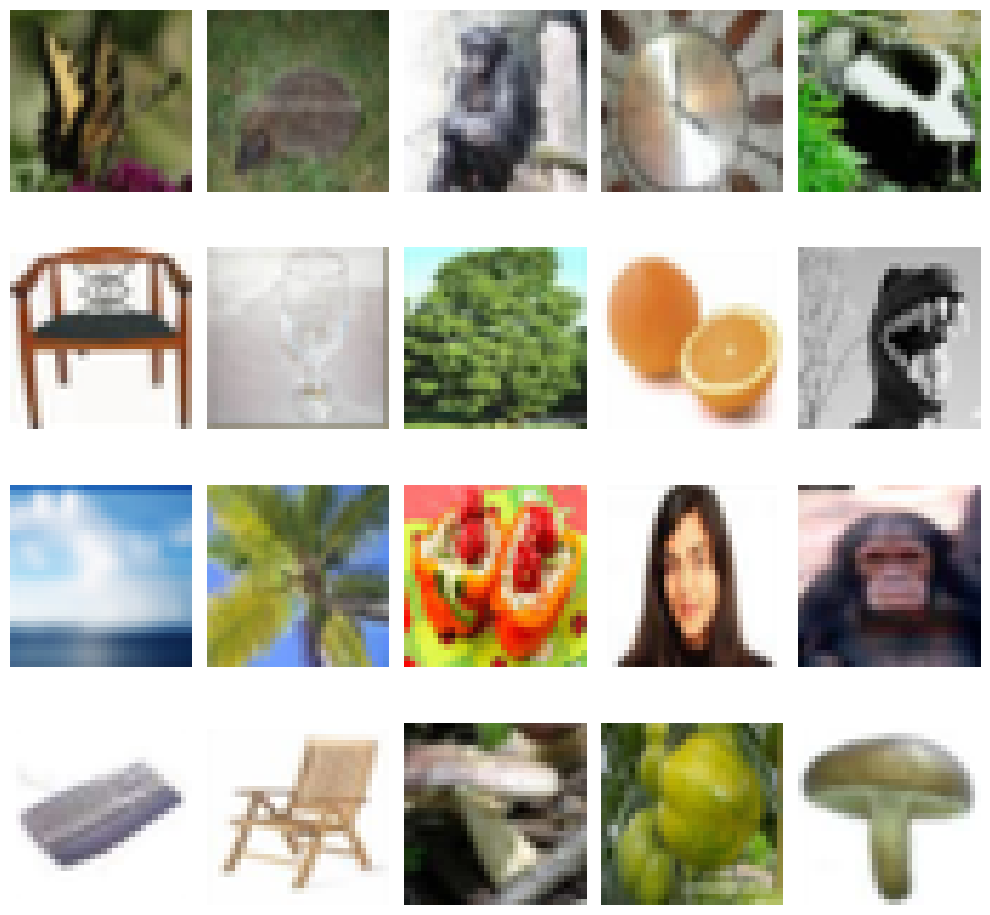

In [25]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    image = X_train[np.random.randint(len(X_train))]
    show_image(image)
plt.tight_layout()
plt.show()

In [26]:
input_shape = X_train.shape[1:]
print(f'Input Image Shape : {input_shape}')

Input Image Shape : (32, 32, 3)


Keep in mind this is a **Very Small Image Size** and does not contain much information.

# **Model Architecture**

## **Model Params**

In [27]:
SIZE = 72
PATCH_SIZE = 6
LR = 0.001
WEIGHT_DECAY = 0.0001
EPOCHS = 100
NUM_PATCHES = (SIZE // PATCH_SIZE) ** 2
PROJECTION_DIMS = 64
NUM_HEADS = 4
HIDDEN_UNITS = [PROJECTION_DIMS*2, PROJECTION_DIMS]
OUTPUT_UNITS = [128,64]

## 1. **Data Augmentation**

In [28]:
class DataAugmentation(Layer):
    def __init__(self, norm, SIZE):
        super(DataAugmentation, self).__init__()
        self.norm = norm
        self.SIZE = SIZE
        self.resize = Resizing(SIZE, SIZE)
        self.flip = RandomFlip('horizontal')
        self.rotation = RandomRotation(factor=0.02)
        self.zoom = RandomZoom(height_factor=0.2, width_factor=0.2)
    def call(self, X):
        x = self.norm(X)
        x = self.resize(x)
        x = self.flip(x)
        x = self.rotation(x)
        x = self.zoom(x)
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
        "norm": self.norm,
        "SIZE": self.SIZE,
        })
        return config

## 2. **Image-to-Patches**

In [29]:
class Patches(Layer):

    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0] # Get the Batch Size
        print(batch_size)
        patches = tfi.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1], # only along the Height and Width Dimension
            strides=[1, self.patch_size, self.patch_size, 1], # The next patch should not overlap the previus patch
            rates=[1,1,1,1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config()
        config.update({
            "path-size": self.patch_size,
        })
        return config

Let's see how his works 

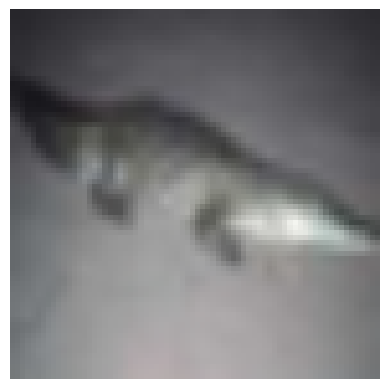

In [30]:
image = X_train[np.random.randint(len(X_train))]
image = tfi.resize(image, (SIZE, SIZE))
image = tf.cast(image,'uint8')
show_image(image)
image = tf.expand_dims(image,0)

In [31]:
patch = Patches(PATCH_SIZE) # patch Size
patches = patch(image)

tf.Tensor(1, shape=(), dtype=int32)


In [32]:
patches.shape # We needed 12 patches

TensorShape([1, 144, 108])

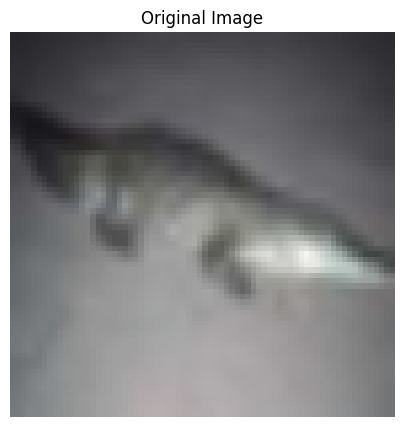

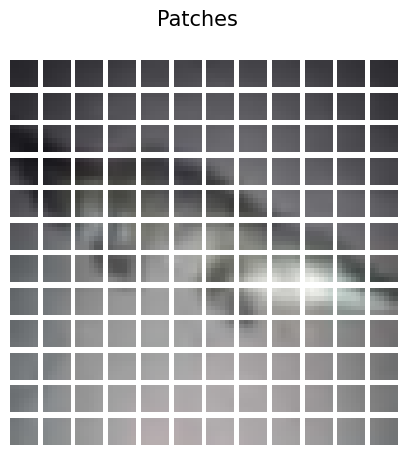

In [33]:
plt.figure(figsize=(5,5))
show_image(image[0], title="Original Image")
plt.show()

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
plt.suptitle("Patches", fontsize=15)
for i in range(patches.shape[-2]):
    plt.subplot(n,n,i+1)
    patch = tf.reshape(patches[0][i],(PATCH_SIZE, PATCH_SIZE, 3))
    patch = tf.cast(patch, 'uint8')
    show_image(patch, cmap='gray')
plt.show()

## 3. **MLP**
---
Patches MLP

In [34]:
class PatchEncoder(Layer):

    def __init__(self, num_patches, projection_dims): # Projection dims is  D
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.d = projection_dims

        self.dense = Dense(units=projection_dims)
        self.positional_embeddings = Embedding(input_dim=num_patches, output_dim=projection_dims)

    def call(self, X):
        positions = tf.range(0,limit=self.num_patches, delta=1)
        encoded = self.dense(X) + self.positional_embeddings(positions)
        return encoded
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_paches": self.num_patches,
            "d": self.d,
        })
        return config

## 4. **MLP**
---
Output MLP

In [35]:
class MLP(Layer):
    def __init__(self, units, rate):
        super(MLP, self).__init__()
        self.units = units
        self.rate = rate
        self.layers = [[Dense(unit, activation=gelu), Dropout(rate)] for unit in units]

    def call(self, x):
        for layers in self.layers:
          for layer in layers:
            x = layer(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "rate": self.rate,
        })
        return config

## **Transformet Network**

In [36]:
class Transformer(Layer):

    def __init__(self, L, num_heads, key_dims, hidden_units):
        super(Transformer, self).__init__()
        self.L = L
        self.heads = num_heads
        self.key_dims = key_dims
        self.hidden_units = hidden_units

        self.norm = LayerNormalization(epsilon=1e-6) # Remember the Params
        self.MHA = MultiHeadAttention(num_heads=num_heads, key_dim=key_dims, dropout=0.1)
        self.net = MLP(units=hidden_units, rate=0.1)
        self.add= Add()

    def call(self, X):
        inputs = X
        x = X
        for _ in range(self.L):
          x = self.norm(x)
          x = self.MHA(x,x) # our Target and the Source element are the same
          y = self.add([x,inputs])
          x = self.norm(y)
          x = self.net(x)
          x = self.add([x,y])
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "L": self.L,
            "heads": self.heads,
            "key_dims":self.key_dims,
            "hidden_units":self.hidden_units
        })
        return config

## **ViT Structure**

In [37]:
# Input Layer
inputs = Input(shape=input_shape)

# Apply Data Aug
norm = Normalization()
norm.adapt(X_train)

x = DataAugmentation(norm, SIZE)(inputs)

# Get Patches
x = Patches(PATCH_SIZE)(x)

# PatchEncoding Network
x = PatchEncoder(NUM_PATCHES, PROJECTION_DIMS)(x)

# Transformer Network
x = Transformer(8, NUM_HEADS, PROJECTION_DIMS, HIDDEN_UNITS)(x)

# Output Network
x = LayerNormalization(epsilon=1e-6)(x)
x = Flatten()(x)
x = Dropout(0.5)(x)

x = MLP(OUTPUT_UNITS, rate=0.5)(x)

# Ouput Layer
outputs = Dense(100)(x)

Tensor("patches_3/strided_slice:0", shape=(), dtype=int32)


## **ViT Model**

In [38]:
with tf.device('/GPU:0'):
  # Model
  model = Model(
    inputs=[inputs],
    outputs=[outputs],
  )

  # Compiling
  model.compile(
      loss=SCCe(from_logits=True),
      optimizer=AdamW(learning_rate=LR, weight_decay=WEIGHT_DECAY),
      metrics=[
          Acc(name="Accuracy"),
          KAcc(5, name="Top-5-Accuracy")
      ]
  )
  model.summary()

  # Callbacks
  cbs = [
    ModelCheckpoint("ViT-Model.h5", save_best_only=True),
    EarlyStopping(patience=5, monitor='val_Accuracy', mode='max' ,restore_best_weights=True)
  ]

  # Fit
  results = model.fit(
      X_train, y_train,
      epochs=EPOCHS,
      validation_data=(X_valid, y_valid),
      callbacks=cbs
  )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation_1 (DataAu  (None, 72, 72, 3)        7         
 gmentation)                                                     
                                                                 
 patches_3 (Patches)         (None, None, 108)         0         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 144, 64)          16192     
 er)                                                             
                                                                 
 transformer_1 (Transformer)  (None, 144, 64)          83072     
                                                                 
 layer_normalization_3 (Laye  (None, 144, 64)          128 

KeyboardInterrupt: 

After 100 epochs(approx), the ViT model achieves around 55% accuracy and 82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset, as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.


---
Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

---
**Thanks!!**